1. Imports and data loading


In [2]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Classification metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Models for text classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

# Load data
train = pd.read_csv("data/train.csv")
print("Shape:", train.shape)
train.head()


Shape: (198000, 15)


,created_date,post_id,emoticon_1,emoticon_2,emoticon_3,upvote,downvote,if_1,if_2,race,religion,gender,disability,comment,label
0,2024-01-18 08:43:57.397508+00:00,73,0,0,0,0,1,0,10,NaN,NaN,NaN,False,She might be a bright spot for a party keou on...,2
1,2024-03-24 21:43:11.490017+00:00,39,0,0,0,6,0,0,4,NaN,NaN,NaN,False,"Under Alaska law, a non-tribal member is not b...",0
2,2024-04-24 20:32:17.014931+00:00,31,0,1,1,0,0,0,10,NaN,NaN,NaN,False,in the future please spare me your strawman dr...,2
3,2023-05-28 22:00:14.214527+00:00,39,0,0,0,5,0,0,10,NaN,NaN,NaN,False,"PS: That should have been ""rot"" instead of ""co...",2
4,2023-09-09 23:12:05.689498+00:00,39,0,0,0,0,0,0,10,NaN,NaN,NaN,False,"Today, the confederate flag...tomorrow, the na...",2


In [15]:
import os
PROJECT_ROOT = os.path.dirname(os.getcwd())  # mlproject/ (one level up from notebook/)
ARTIFACTS_PATH = os.path.join(PROJECT_ROOT, "artifacts")

print(f"Saving to: {ARTIFACTS_PATH}")


Saving to: c:\Users\anish\Documents\MLPROJECT2\artifacts


2. Data preparation


In [3]:
# Target encoding (if label is string)
le = LabelEncoder()
train["label_encoded"] = le.fit_transform(train["label"])
print("Label classes:", dict(zip(le.classes_, le.transform(le.classes_))))

# Features
text_col = "comment"
num_cols = ["upvote", "downvote", "if_1", "if_2"]
cat_cols = ["race", "religion", "gender", "disability", 
            "emoticon_1", "emoticon_2", "emoticon_3"]

# Engineering quick text features
train["comment_len"] = train[text_col].astype(str).str.len()
train["word_count"] = train[text_col].astype(str).str.split().map(len)
num_cols += ["comment_len", "word_count"]

X = train.drop(["label", "label_encoded", "post_id", "created_date"], axis=1)
y = train["label_encoded"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)
print("Train shape:", X_train.shape)


Label classes: {0: 0, 1: 1, 2: 2, 3: 3}
Train shape: (158400, 14)


3. Preprocessing pipeline


In [4]:
from sklearn.preprocessing import OneHotEncoder

# Fix NaN comments first
X_train[text_col] = X_train[text_col].fillna("").astype(str)
X_test[text_col] = X_test[text_col].fillna("").astype(str)

# Separate numeric and categorical properly
true_num_cols = ["upvote", "downvote", "if_1", "if_2", "comment_len", "word_count"]
true_cat_cols = ["race", "religion", "gender"]  # strings
binary_cols = ["disability", "emoticon_1", "emoticon_2", "emoticon_3"]  # 0/1

# Preprocessor with proper handling
preprocessor = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(max_features=5000, ngram_range=(1,2)), text_col),
        ("num", StandardScaler(), true_num_cols),
        ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), true_cat_cols),
        ("binary", "passthrough", binary_cols)
    ])

# Test
X_train_pre = preprocessor.fit_transform(X_train)
print("Processed train shape:", X_train_pre.shape)


Processed train shape: (158400, 5032)


Training and compare models 

In [ ]:
models = {
    "LogisticRegression": LogisticRegression(random_state=42, max_iter=1000),
    
    
}

results = {}
for name, model in models.items():
    pipe = Pipeline([("prep", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")

    results[name] = {"Accuracy": acc, "Macro F1": f1}
    print(f"{name}: Acc={acc:.4f}, F1={f1:.4f}")

results_df = pd.DataFrame(results).T
results_df.sort_values("Macro F1", ascending=False)


LogisticRegression: Acc=0.9024, F1=0.7835
LinearSVC: Acc=0.8084, F1=0.6878
XGBoost: Acc=0.9055, F1=0.7747


,Accuracy,Macro F1
LogisticRegression,0.902399,0.783510
XGBoost,0.905505,0.774685
LinearSVC,0.808409,0.687808


Best Model Evaluation 

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95     22835
           1       0.77      0.72      0.74      3183
           2       0.84      0.91      0.87     12488
           3       0.75      0.45      0.56      1094

    accuracy                           0.90     39600
   macro avg       0.83      0.76      0.78     39600
weighted avg       0.90      0.90      0.90     39600



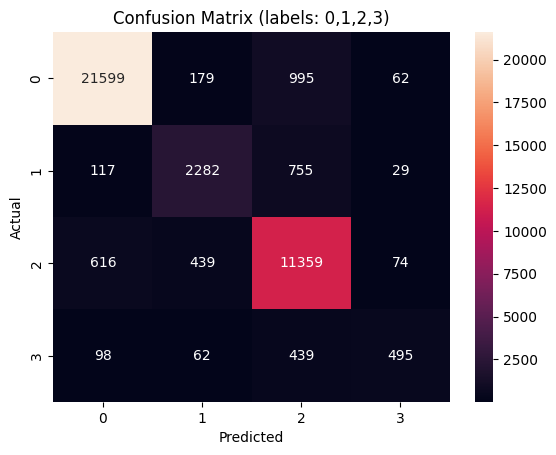


Sample predictions:
   Actual  Predicted
0       2          0
1       0          0
2       1          1
3       2          2
4       0          0
5       0          2
6       2          2
7       0          0
8       1          1
9       2          2


In [7]:
# Use best model
best_pipe = Pipeline([
    ("prep", preprocessor), 
    ("model", LogisticRegression(random_state=42, max_iter=1000))
])
best_pipe.fit(X_train, y_train)

y_pred = best_pipe.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix with numeric labels (0,1,2,3)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.title("Confusion Matrix (labels: 0,1,2,3)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Decode predictions to original labels for readability
y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)
print("\nSample predictions:")
print(pd.DataFrame({
    "Actual": y_test_labels[:10],
    "Predicted": y_pred_labels[:10]
}))



Save model and preprocessor

In [16]:
import joblib

# Save to MAIN project artifacts (outside notebook/)
joblib.dump(best_pipe, os.path.join(ARTIFACTS_PATH, "best_comment_classifier.pkl"))
joblib.dump(le, os.path.join(ARTIFACTS_PATH, "label_encoder.pkl"))
joblib.dump(preprocessor, os.path.join(ARTIFACTS_PATH, "preprocessor.pkl"))

print("✅ SAVED to mlproject/artifacts/ (outside notebook folder)")
print("- best_comment_classifier.pkl")
print("- label_encoder.pkl") 
print("- preprocessor.pkl")


✅ SAVED to mlproject/artifacts/ (outside notebook folder)
- best_comment_classifier.pkl
- label_encoder.pkl
- preprocessor.pkl
